In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import ipywidgets as widgets
from ipywidgets import fixed, interact_manual, widgets
from IPython.display import display
import copy
from scipy.optimize import curve_fit
from scipy.stats import linregress
import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Local module and scripts
from pyccapt.calibration.calibration import tools, share_variables
from pyccapt.calibration.calibration import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools
from pyccapt.calibration.calibration import share_variables
from pyccapt.calibration.calibration import mc_plot

In [2]:
variables = share_variables.Variables()

In [3]:
# button = widgets.Button(description='load dataset')

# @button.on_click
# def open_file_on_click_r(b):
#     global dataset_path
#     folder_path = variables.last_directory
#     script = '..//..//data_tools//run_dataset_path_qt.py'
#     cmd = f"python {script} {folder_path}"
#     result = subprocess.run(cmd, capture_output=True, text=True, shell=True)
#     dataset_path = result.stdout.strip()
#     variables.last_directory = dataset_path

# button

In [4]:
# flightPathLength = 243 # 105.35 # mm 
# # The initial value for t_0
# t0 = 33 #68.48 # ns

# dataset name
# data_115_Jul-27-2022_17-44_Powersweep3

In [5]:
# ref_angle = 260
# ref_laser_intensity = 1.4e13
# pulse_energy = ref_laser_intensity * (10 ** ((angle - ref_angle) / (270 * 0.5)))
# # 1 μm^2 =1×10^−8 cm^2
# #Energy per pulse (J) = Power Density (W/cm^2) * Area (cm^2) * Pulse Duration (s)
# pulse_energy = pulse_energy * 6e-8 *  12e-15 * 1e12
# variables.data['pulse'] = pulse_energy

$$\textbf{You can specify the model of the TDC and dataset name down below}$$

In [6]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_instrument_specification_selection()
display(tdc, pulse_mode)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'leap_apt', 'ato_v6'), value='…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

In [7]:
# dataset_path_171fs = 'D:/pyccapt/tests/data/physics_experiment/data_115_Jul-27-2022_17-44_Powersweep3/data_processing/data_115_Jul-27-2022_17-44_Powersweep3.h5'
# dataset_path_12fs =  'D:/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
# dataset_path_12ps = 'D:/pyccapt/tests/data/physics_experiment/R56_06712-v01/data_processing/R56_06712-v01.h5'
dataset_path_171fs = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/data_115_Jul-27-2022_17-44_Powersweep3/data_processing/data_115_Jul-27-2022_17-44_Powersweep3.h5'
dataset_path_12fs =  'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
dataset_path_12ps = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests\data/physics_experiment/R56_06712-v01/data_processing/R56_06712-v01.h5'

In [8]:
# exctract needed data from Pandas data frame as an numpy array
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode

variables.result_data_path = 'D:/pyccapt/tests/data/physics_experiment/results' 
variables.result_data_name = 'power_sweep'
variables.result_path ='D:/pyccapt/tests/data/physics_experiment/results'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
# Create data farame out of hdf5 file dataset
data_171fs = data_tools.load_data(dataset_path_171fs, tdc.value, mode='processed')
data_12fs = data_tools.load_data(dataset_path_12fs, tdc.value, mode='processed')
data_12ps = data_tools.load_data(dataset_path_12ps, tdc.value, mode='processed')


In [9]:
data_12fs

,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,-2.767831,0.628515,0.222740,92.890632,97.226183,7438.498535,4338.635254,2079.6352,97.016393,-2.701980,0.613562,0,1,12052
1,-0.164489,2.808282,0.219238,61.100704,63.410943,7438.498535,4338.635254,1685.6557,63.807931,-0.160550,2.741040,2,1,12054
2,0.540758,0.504136,0.016351,245.548935,256.019707,7438.498535,4338.635254,3334.8123,256.414306,0.523603,0.488143,3,1,12057
3,-0.099146,-0.394739,0.006351,92.962785,97.225079,7438.498535,4338.635254,2067.1255,97.086209,-0.095961,-0.382060,2,1,12059
4,2.374801,2.905199,0.392576,60.690303,62.772022,7438.498535,4338.635254,1685.3541,63.378481,2.333800,2.855040,3,1,12062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736748,3.017963,0.668915,416.606516,99.168086,102.891027,6101.266113,10792.778320,2369.0614,103.494988,3.616390,0.801553,2,1,1150022
736749,0.492738,-2.392287,416.485023,91.208599,95.866680,6101.266113,10792.778320,2278.3927,95.171874,0.586963,-2.849760,1,1,1150023
736750,-0.548637,3.143877,416.629384,60.804203,62.975795,6101.266113,10792.778320,1861.9732,63.449615,-0.658113,3.771210,1,1,1150024
736751,1.658814,1.805123,416.487868,91.138283,94.474835,6101.266113,10792.778320,2262.1487,95.111530,1.976170,2.150470,3,1,1150027


In [10]:
print('The data will be saved on the path:', variables.result_data_path)
print('=============================')
print('The dataset name after saving is:', variables.result_data_name)
print('=============================')
print('The figures will be saved on the path:', variables.result_path)
print('=============================')
print('Total number of Ions: data_171fs', len(data_171fs))
print('Total number of Ions: data_12fs', len(data_12fs))
print('Total number of Ions: data_12ps', len(data_12ps))


The data will be saved on the path: D:/pyccapt/tests/data/physics_experiment/results
The dataset name after saving is: power_sweep
The figures will be saved on the path: D:/pyccapt/tests/data/physics_experiment/results
Total number of Ions: data_171fs 505212
Total number of Ions: data_12fs 736753
Total number of Ions: data_12ps 549703


In [11]:
# laser_power = np.zeros(len(data['high_voltage (V)'].to_numpy()))
# print(len(laser_power))
# laser_power[0:22100] = 50
# laser_power[22100:50000] = 60 #pJ
# laser_power[50000:100000] = 70
# laser_power[100000:150000] = 80
# laser_power[150000:200000] = 90
# laser_power[200000:250000] = 100
# laser_power[250000:300000] = 110
# laser_power[300000:350000] = 120
# laser_power[350000:400000] = 130
# laser_power[400000:450000] = 140
# laser_power[450000:500000] = 150
# laser_power[500000:550000] = 160


# data.insert(6, 'pulse (deg)', laser_power)
# del data['pulse']

In [12]:
# # the difference that we have between laser intensity
# intensity = data['pulse'].to_numpy()
# new_intensity = np.unique(intensity)
# for i in range(len(new_intensity)):
#     if i+1 < len(new_intensity):
#         print(new_intensity[i+1] - new_intensity[i])

In [21]:
def find_step_changes(array):
    step_changes = []
    prev_value = array[0]
    
    for i in range(1, len(array)):
        if array[i] > prev_value:
            step_changes.append(i)
            prev_value = array[i]

    return step_changes

def calculate_step_means(array, step_changes):
    step_means = []

    for i in range(len(step_changes) - 1):
        start_index = step_changes[i]
        end_index = step_changes[i + 1]
        step_mean = sum(array[start_index:end_index]) / (end_index - start_index)
        step_means.append(step_mean)

    # Calculate mean for the last step
    last_step_mean = sum(array[step_changes[-1]:]) / (len(array) - step_changes[-1])
    step_means.append(last_step_mean)

    return step_means

def calculate_step_values(array, step_changes):
    step_values = []

    for i in range(len(step_changes) - 1):
        start_index = step_changes[i]
        end_index = step_changes[i + 1]
        values_in_step = array[start_index:end_index]
        step_values.append(values_in_step)

    # Values for the last step
    values_in_last_step = array[step_changes[-1]:]
    step_values.append(values_in_last_step)

    return step_values

def extract_step_values(array, step_changes):
    step_values = []

    for index in step_changes:
        step_values.append(array[index])

    return step_values

def ratio_calculator(mc, range_1, range_2, range_3):
    ratios_tmp_w2_3 = []
    ratios_tmp_w1_2 = []
    ratios_tmp_w2_3_r = []
    ratios_tmp_w1_2_r = []
    for i, mc_step in enumerate(mc):

        W_3pluse = mc_step[(mc_step > range_3[0]) & (mc_step < range_3[1])]
        W_2pluse = mc_step[(mc_step > range_2[0]) & (mc_step < range_2[1])]
        W_1pluse = mc_step[(mc_step > range_1[0]) & (mc_step < range_1[1])]

        try:
            bin_size = 0.1
            num_bins = int((W_3pluse.max() - W_3pluse.min()) / bin_size)
            # Create histogram with specified bin size
            hist, bin_edges = np.histogram(W_3pluse, bins=num_bins)
            # Find the bin with the maximum occurrence
            max_occurrence_index = np.argmax(hist)
            # Get the value range corresponding to the bin with the maximum occurrence
            w3 = max_occurrence_height = hist[max_occurrence_index]
        except:
            print('There is not possible to find peak W+++')
            w3 = len(W_3pluse)

        num_bins = int((W_2pluse.max() - W_2pluse.min()) / bin_size)
        # Create histogram with specified bin size
        hist, bin_edges = np.histogram(W_2pluse, bins=num_bins)
        # Find the bin with the maximum occurrence
        max_occurrence_index = np.argmax(hist)
        # Get the value range corresponding to the bin with the maximum occurrence
        w2 = max_occurrence_height = hist[max_occurrence_index]

        try:
            num_bins = int((W_1pluse.max() - W_1pluse.min()) / bin_size)
            # Create histogram with specified bin size
            hist, bin_edges = np.histogram(W_1pluse, bins=num_bins)
            # Find the bin with the maximum occurrence
            max_occurrence_index = np.argmax(hist)
            # Get the value range corresponding to the bin with the maximum occurrence
            w1 = max_occurrence_height = hist[max_occurrence_index]
        except:
            print('There is not possible to find peak W+')
            w1 = len(W_1pluse)

        ratios_tmp_w2_3.append(w2/w3)
        ratios_tmp_w1_2.append(w1/w2)
        
        ratios_tmp_w2_3_r.append(len(W_2pluse)/len(W_3pluse))
        ratios_tmp_w1_2_r.append(len(W_1pluse)/len(W_2pluse))
        
    return ratios_tmp_w1_2, ratios_tmp_w2_3, ratios_tmp_w1_2_r, ratios_tmp_w2_3_r

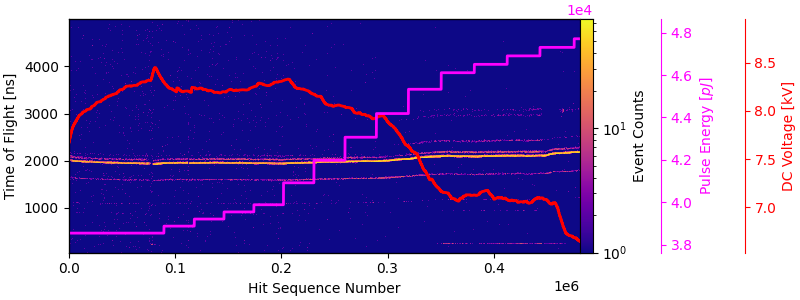

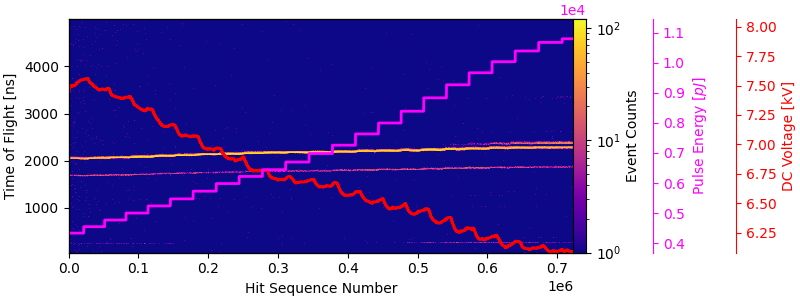

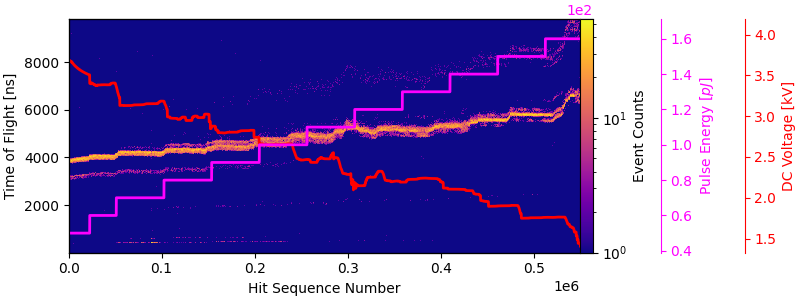

In [22]:
data_loadcrop.plot_crop_experiment_history(data_171fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')
data_loadcrop.plot_crop_experiment_history(data_12fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')
data_loadcrop.plot_crop_experiment_history(data_12ps, variables, max_tof=15000, data_crop=False, pulse_plot=True, pulse_mode='laser')

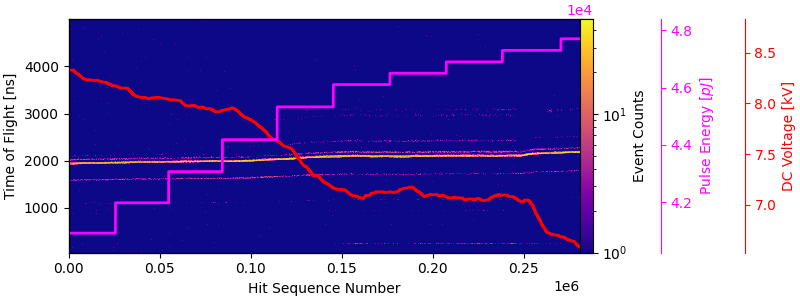

In [16]:
# Assuming 'df' is your DataFrame
cropped_data_171fs = data_171fs.iloc[200000:].reset_index(drop=True)
# cropped_data_171fs = data_171fs.iloc[0:].reset_index(drop=True)
data_loadcrop.plot_crop_experiment_history(cropped_data_171fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')

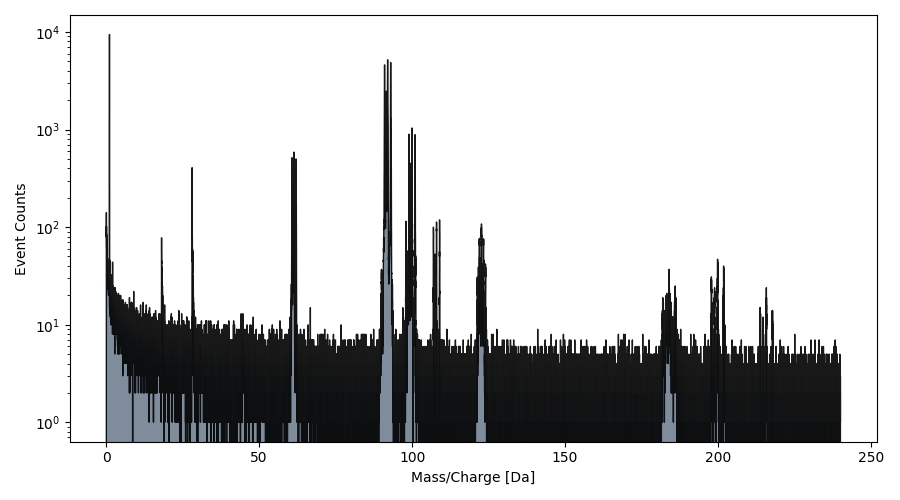

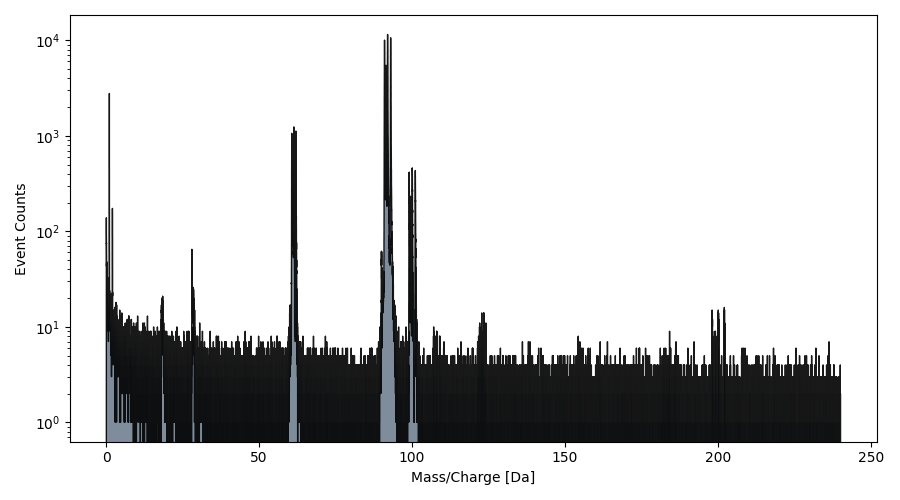

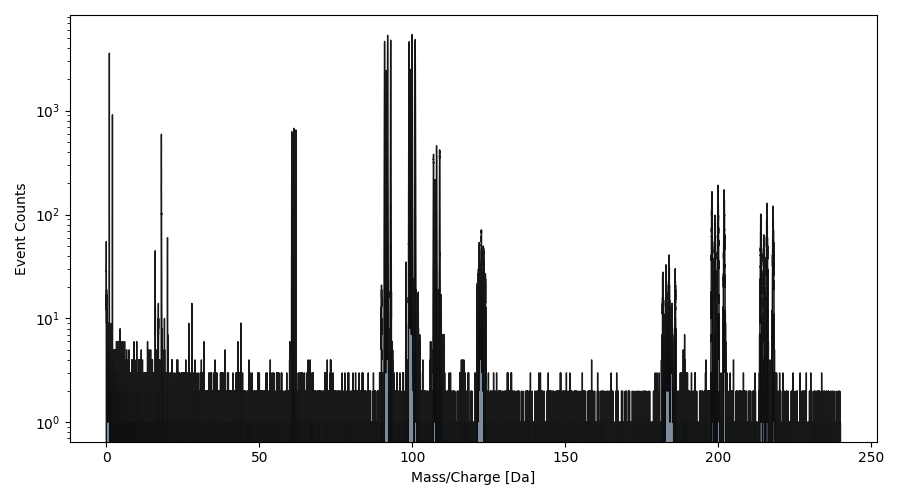

In [17]:
bin_size = 0.01
hist = data_171fs['mc (Da)'].to_numpy()
mc_hist = mc_plot.AptHistPlotter(hist[hist < 240], variables)
mc_hist.plot_histogram(bin_width=bin_size, label='mc', steps='stepfilled', log=True)
mc_hist.find_peaks_and_widths()
mc_hist.plot_hist_info_legend(loc='right')
hist = data_12fs['mc (Da)'].to_numpy()
mc_hist = mc_plot.AptHistPlotter(hist[hist < 240], variables)
mc_hist.plot_histogram(bin_width=bin_size, label='mc', steps='stepfilled', log=True)
mc_hist.find_peaks_and_widths()
mc_hist.plot_hist_info_legend(loc='right')
hist = data_12ps['mc_c (Da)'].to_numpy()
mc_hist = mc_plot.AptHistPlotter(hist[hist < 240], variables)
mc_hist.plot_histogram(bin_width=bin_size, label='mc', steps='stepfilled', log=True)
mc_hist.find_peaks_and_widths()
mc_hist.plot_hist_info_legend(loc='right')

9


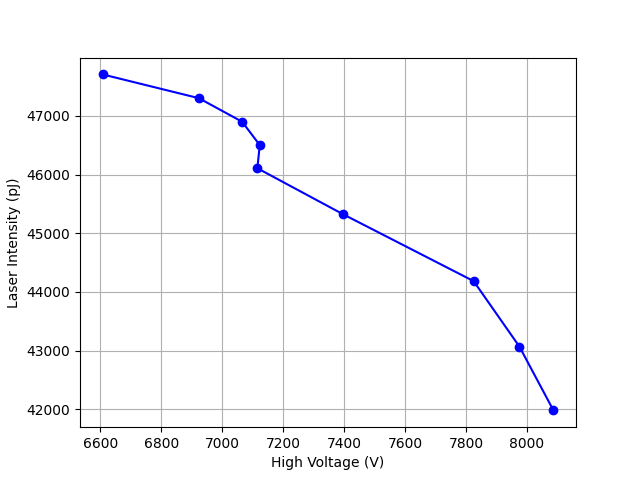

In [18]:
intensity = cropped_data_171fs['pulse'].to_numpy()
dc_voltage = cropped_data_171fs['high_voltage (V)'].to_numpy()
mc = cropped_data_171fs['mc (Da)'].to_numpy()

steps = find_step_changes(intensity)
print(len(steps))
intensity_values_171fs = extract_step_values(intensity, steps)
# intensity_values = np.log(intensity_values)
voltage_means_171fs = calculate_step_means(dc_voltage, steps)
mc_steps_171fs = calculate_step_values(mc, steps)

# Plotting
# Create a figure and axis
fig, ax = plt.subplots()
plt.plot(voltage_means_171fs, intensity_values_171fs, marker='o', linestyle='-', color='b')

plt.xlabel('High Voltage (V)')
plt.ylabel('Laser Intensity (pJ)')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

22


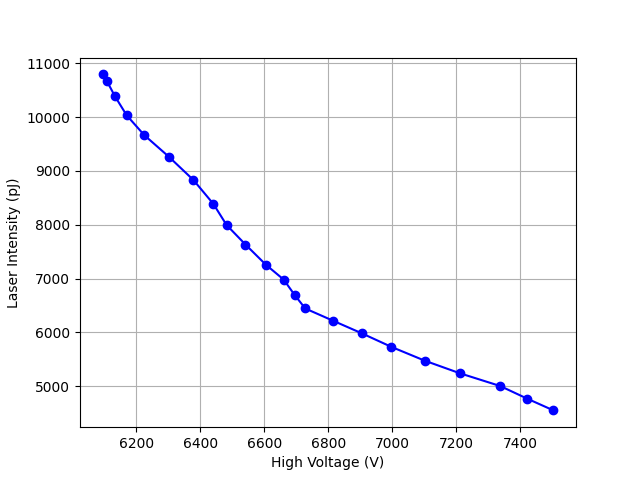

In [19]:
intensity = data_12fs['pulse'].to_numpy()
dc_voltage = data_12fs['high_voltage (V)'].to_numpy()
mc = data_12fs['mc (Da)'].to_numpy()

steps = find_step_changes(intensity)
print(len(steps))
intensity_values_12fs = extract_step_values(intensity, steps)
# intensity_values = np.log(intensity_values)
voltage_means_12fs = calculate_step_means(dc_voltage, steps)
mc_steps_12fs = calculate_step_values(mc, steps)

# Plotting
# Create a figure and axis
fig, ax = plt.subplots()
plt.plot(voltage_means_12fs, intensity_values_12fs, marker='o', linestyle='-', color='b')

plt.xlabel('High Voltage (V)')
plt.ylabel('Laser Intensity (pJ)')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

11


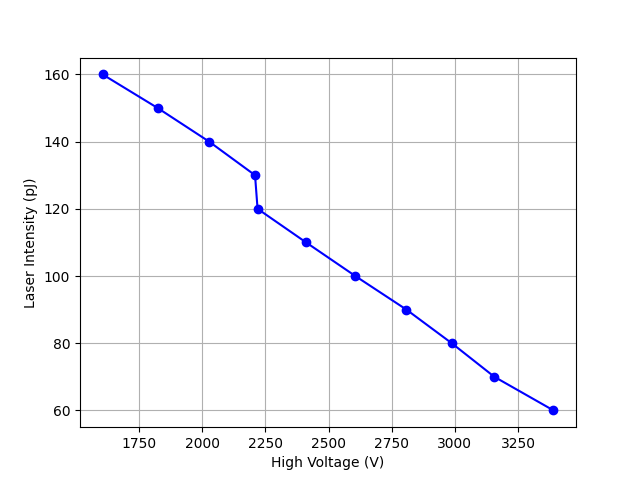

In [20]:
intensity = data_12ps['pulse'].to_numpy()
dc_voltage = data_12ps['high_voltage (V)'].to_numpy()
mc = data_12ps['mc_c (Da)'].to_numpy()

steps = find_step_changes(intensity)
print(len(steps))
intensity_values_12ps = extract_step_values(intensity, steps)
# intensity_values = np.log(intensity_values)
voltage_means_12ps = calculate_step_means(dc_voltage, steps)
mc_steps_12ps = calculate_step_values(mc, steps)

# Plotting
# Create a figure and axis
fig, ax = plt.subplots()
plt.plot(voltage_means_12ps, intensity_values_12ps, marker='o', linestyle='-', color='b')

plt.xlabel('High Voltage (V)')
plt.ylabel('Laser Intensity (pJ)')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [23]:
ratios_w2_3 = []  # List to store the ratios
ratios_w2_3_r = []  # List to store the ratios
ratios_w1_2 = []  # List to store the ratios
ratios_w1_2_r = []  # List to store the ratios

In [24]:
# 171fs
range_1 = [183.7, 184.2]
range_2 = [91.7, 92.3]
range_3 = [61.2, 61.6]
    
ratios_w1_2_tmp, ratios_w2_3_tmp, ratios_w1_2_r_tmp, ratios_w2_3_r_tmp = ratio_calculator(mc_steps_171fs, range_1, range_2, range_3)
ratios_w1_2.append(ratios_w1_2_tmp)
ratios_w2_3.append(ratios_w2_3_tmp)
ratios_w1_2_r.append(ratios_w1_2_r_tmp)
ratios_w2_3_r.append(ratios_w2_3_r_tmp)

In [25]:
# 12fs

range_1 = [184.0, 184.2]
range_2 = [91.7, 92.4]
range_3 = [61.1, 61.6]

ratios_w1_2_tmp, ratios_w2_3_tmp, ratios_w1_2_r_tmp, ratios_w2_3_r_tmp = ratio_calculator(mc_steps_12fs, range_1, range_2, range_3)
ratios_w1_2.append(ratios_w1_2_tmp)
ratios_w2_3.append(ratios_w2_3_tmp)
ratios_w1_2_r.append(ratios_w1_2_r_tmp)
ratios_w2_3_r.append(ratios_w2_3_r_tmp)

There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+
There is not possible to find peak W+


In [26]:
# 12ps
range_1 = [183.6, 184.2]
range_2 = [91.7, 92.2]
range_3 = [61.1, 61.4]

ratios_w1_2_tmp, ratios_w2_3_tmp, ratios_w1_2_r_tmp, ratios_w2_3_r_tmp = ratio_calculator(mc_steps_12ps, range_1, range_2, range_3)
ratios_w1_2.append(ratios_w1_2_tmp)
ratios_w2_3.append(ratios_w2_3_tmp)
ratios_w1_2_r.append(ratios_w1_2_r_tmp)
ratios_w2_3_r.append(ratios_w2_3_r_tmp)


There is not possible to find peak W+++
There is not possible to find peak W+++


In [27]:
ratio_12_ps_w2_3 = np.array(ratios_w2_3[2])
ratio_12_fs_w2_3 = np.array(ratios_w2_3[1])
ratio_171_fs_w2_3 = np.array(ratios_w2_3[0])

ratio_12_ps_r_w2_3 = np.array(ratios_w2_3_r[2])
ratio_12_fs_r_w2_3 = np.array(ratios_w2_3_r[1])
ratio_171_fs_r_w2_3 = np.array(ratios_w2_3_r[0])

ratio_12_ps_w1_2= np.array(ratios_w1_2[2])
ratio_12_fs_w1_2 = np.array(ratios_w1_2[1])
ratio_171_fs_w1_2 = np.array(ratios_w1_2[0])

ratio_12_ps_r_w1_2 = np.array(ratios_w1_2_r[2])
ratio_12_fs_r_w1_2 = np.array(ratios_w1_2_r[1])
ratio_171_fs_r_w1_2 = np.array(ratios_w1_2_r[0])



pe_12_ps = np.array(intensity_values_12ps)
pe_12_fs = np.array(intensity_values_12fs)
pe_171_fs = np.array(intensity_values_171fs)


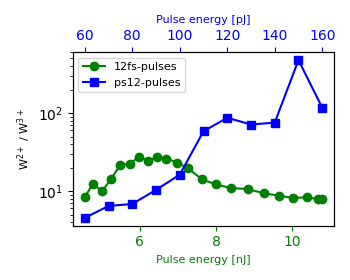

In [28]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_w2_3, marker='o', label='12fs-pulses', color='green')

ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{2+}$ / W$^{3+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
ax1.set_yscale('log')


ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_12_ps, ratio_12_ps_w2_3, marker='s', color='blue', label='ps12-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='blue')  # Set Y-axis tick labels color to red

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

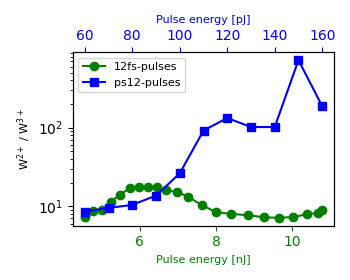

In [29]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w2_3, marker='o', label='12fs-pulses', color='green')

ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{2+}$ / W$^{3+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
ax1.set_yscale('log')


ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_12_ps, ratio_12_ps_r_w2_3, marker='s', color='blue', label='ps12-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='blue')  # Set Y-axis tick labels color to red

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

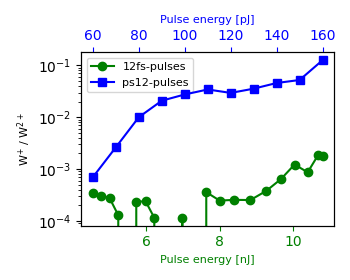

In [30]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w1_2, marker='o', label='12fs-pulses', color='green')

ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{+}$ / W$^{2+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
ax1.set_yscale('log')


ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_12_ps, ratio_12_ps_r_w1_2, marker='s', color='blue', label='ps12-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='blue')  # Set Y-axis tick labels color to red

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

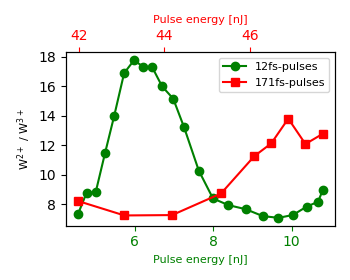

In [31]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w2_3, marker='o', label='12fs-pulses', color='green')

ax1.set_ylabel('W$^{2+}$ / W$^{3+}$')
ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{2+}$ / W$^{3+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
# ax1.set_yscale('log')

ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_171_fs / 1e3, ratio_171_fs_r_w2_3, marker='s', color='red', label='171fs-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [nJ]', color='red', fontsize=8)
ax2.tick_params(axis='x', colors='red')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='red')  # Set Y-axis tick labels color to red


# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

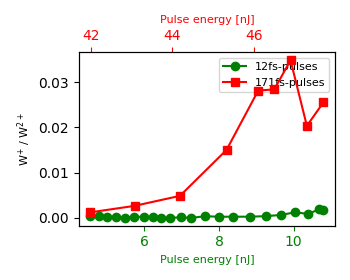

In [32]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w1_2, marker='o', label='12fs-pulses', color='green')


ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{+}$ / W$^{2+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
# ax1.set_yscale('log')

ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_171_fs / 1e3, ratio_171_fs_r_w1_2, marker='s', color='red', label='171fs-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [nJ]', color='red', fontsize=8)
ax2.tick_params(axis='x', colors='red')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='red')  # Set Y-axis tick labels color to red


# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

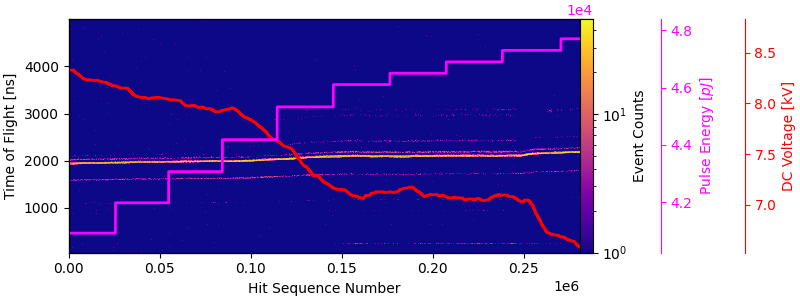

In [33]:
# Assuming 'df' is your DataFrame
cropped_data_171fs = data_171fs.iloc[200000:].reset_index(drop=True)
data_loadcrop.plot_crop_experiment_history(cropped_data_171fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')

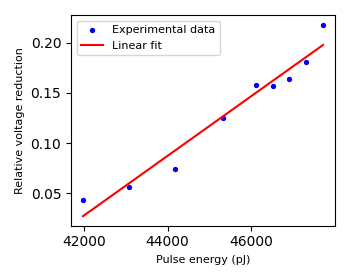

In [34]:
# Convert lists to NumPy arrays
intensity_values_s = np.array(intensity_values_171fs)
voltage_means_s = np.array(voltage_means_171fs)
dc_voltage = data_171fs['high_voltage (V)'].to_numpy()

intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))
# intensity_values_s = (intensity_values_s) / (np.max(intensity_values_s))
# intensity_values_s = (intensity_values_s) / 40000
voltage_means_s = (np.max(dc_voltage) - voltage_means_s) / np.max(dc_voltage)


# voltage_means_s = np.array(voltage_reduction)
# Split the data into two ranges (0 to 19 and 20 to the end)
intensity_values_1 = intensity_values_s[:]
voltage_means_1 = voltage_means_s[:]

log_intensity_values_1 = intensity_values_1

# Define linear and quadratic functions for log-transformed data
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for both ranges
params_linear_log_1, _ = curve_fit(linear_func, log_intensity_values_1, voltage_means_1)
# params_linear_log_2, _ = curve_fit(linear_func_log, voltage_means_2, log_intensity_values_2)

# Fit quadratic function for both ranges
params_quadratic_log_1, _ = curve_fit(square_root_func, log_intensity_values_1, voltage_means_1)
# params_quadratic_log_2, _ = curve_fit(quadratic_func_log, voltage_means_2, log_intensity_values_2)


fig = plt.figure(figsize=(3.5,2.8))
ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)

# Plotting for the first range (0 to 19)
ax.scatter(np.array(intensity_values_171fs), voltage_means_1, label='Experimental data', color='b', s=8)
# x_fit = np.linspace(min(log_intensity_values_1), max(log_intensity_values_1), 100)
ax.plot(np.array(intensity_values_171fs), linear_func(log_intensity_values_1, *params_linear_log_1), label='Linear fit', color='r')
# ax.plot(np.array(intensity_values_171fs), square_root_func(log_intensity_values_1, *params_quadratic_log_1), label='Square-root fit', color='g')


# plt.yscale('log')  # Set y-axis to logarithmic scale
ax.set_ylabel('Relative voltage reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)



# scatter_plot = ax2.scatter(intensity_values, voltage_means, color='b')
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.set_ylabel('Voltage [V]')
# ax2.set_xlabel('Pulse energy [pJ]')
# scatter_plot.remove()
# plt.grid(True)
plt.tight_layout()
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['svg.fonttype'] = 'none'
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.svg", format="svg", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.svg", format="svg", dpi=600)

plt.show()


C:\Users\mehrp\AppData\Local\Temp\ipykernel_39636\2000242431.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3.5,2.8))


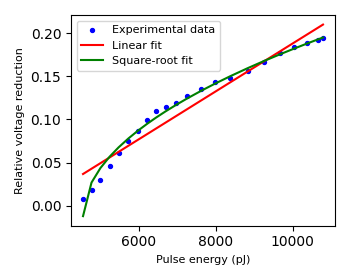

In [35]:
# Convert lists to NumPy arrays
intensity_values_s = np.array(intensity_values_12fs)
voltage_means_s = np.array(voltage_means_12fs)
dc_voltage = data_12fs['high_voltage (V)'].to_numpy()

intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))
# intensity_values_s = (intensity_values_s) / (np.max(intensity_values_s))
# intensity_values_s = (intensity_values_s) / 40000
voltage_means_s = (np.max(dc_voltage) - voltage_means_s) / np.max(dc_voltage)


# voltage_means_s = np.array(voltage_reduction)
# Split the data into two ranges (0 to 19 and 20 to the end)
intensity_values_1 = intensity_values_s[:]
voltage_means_1 = voltage_means_s[:]

log_intensity_values_1 = intensity_values_1

# Define linear and quadratic functions for log-transformed data
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for both ranges
params_linear_log_1, _ = curve_fit(linear_func, log_intensity_values_1, voltage_means_1)
# params_linear_log_2, _ = curve_fit(linear_func_log, voltage_means_2, log_intensity_values_2)

# Fit quadratic function for both ranges
params_quadratic_log_1, _ = curve_fit(square_root_func, log_intensity_values_1, voltage_means_1)
# params_quadratic_log_2, _ = curve_fit(quadratic_func_log, voltage_means_2, log_intensity_values_2)


fig = plt.figure(figsize=(3.5,2.8))
ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)

# Plotting for the first range (0 to 19)
ax.scatter(np.array(intensity_values_12fs), voltage_means_1, label='Experimental data', color='b', s=8)
# x_fit = np.linspace(min(log_intensity_values_1), max(log_intensity_values_1), 100)
ax.plot(np.array(intensity_values_12fs), linear_func(log_intensity_values_1, *params_linear_log_1), label='Linear fit', color='r')
ax.plot(np.array(intensity_values_12fs), square_root_func(log_intensity_values_1, *params_quadratic_log_1), label='Square-root fit', color='g')


# plt.yscale('log')  # Set y-axis to logarithmic scale
ax.set_ylabel('Relative voltage reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)



# scatter_plot = ax2.scatter(intensity_values, voltage_means, color='b')
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.set_ylabel('Voltage [V]')
# ax2.set_xlabel('Pulse energy [pJ]')
# scatter_plot.remove()
# plt.grid(True)
plt.tight_layout()
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['svg.fonttype'] = 'none'
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.svg", format="svg", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.svg", format="svg", dpi=600)

plt.show()


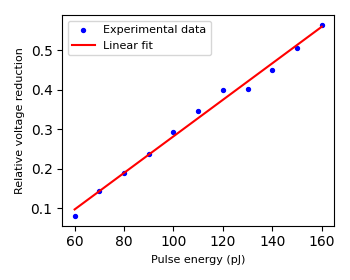

In [36]:
# Convert lists to NumPy arrays
intensity_values_s = np.array(intensity_values_12ps)
voltage_means_s = np.array(voltage_means_12ps)
dc_voltage = data_12ps['high_voltage (V)'].to_numpy()

intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))
# intensity_values_s = (intensity_values_s) / (np.max(intensity_values_s))
# intensity_values_s = (intensity_values_s) / 40000
voltage_means_s = (np.max(dc_voltage) - voltage_means_s) / np.max(dc_voltage)


# voltage_means_s = np.array(voltage_reduction)
# Split the data into two ranges (0 to 19 and 20 to the end)
intensity_values_1 = intensity_values_s[:]
voltage_means_1 = voltage_means_s[:]

log_intensity_values_1 = intensity_values_1

# Define linear and quadratic functions for log-transformed data
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for both ranges
params_linear_log_1, _ = curve_fit(linear_func, log_intensity_values_1, voltage_means_1)
# params_linear_log_2, _ = curve_fit(linear_func_log, voltage_means_2, log_intensity_values_2)

# Fit quadratic function for both ranges
params_quadratic_log_1, _ = curve_fit(square_root_func, log_intensity_values_1, voltage_means_1)
# params_quadratic_log_2, _ = curve_fit(quadratic_func_log, voltage_means_2, log_intensity_values_2)


fig = plt.figure(figsize=(3.5,2.8))
ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)

# Plotting for the first range (0 to 19)
ax.scatter(np.array(intensity_values_12ps), voltage_means_1, label='Experimental data', color='b', s=8)
# x_fit = np.linspace(min(log_intensity_values_1), max(log_intensity_values_1), 100)
ax.plot(np.array(intensity_values_12ps), linear_func(log_intensity_values_1, *params_linear_log_1), label='Linear fit', color='r')
# ax.plot(np.array(voltage_means_12ps), square_root_func(log_intensity_values_1, *params_quadratic_log_1), label='Square-root fit', color='g')


# plt.yscale('log')  # Set y-axis to logarithmic scale
ax.set_ylabel('Relative voltage reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)



# scatter_plot = ax2.scatter(intensity_values, voltage_means, color='b')
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.set_ylabel('Voltage [V]')
# ax2.set_xlabel('Pulse energy [pJ]')
# scatter_plot.remove()
# plt.grid(True)
plt.tight_layout()
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['svg.fonttype'] = 'none'
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.svg", format="svg", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.svg", format="svg", dpi=600)

plt.show()


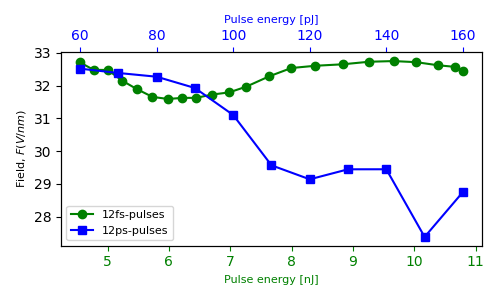

In [44]:
# static filed calculation
# Based on the https://academic.oup.com/mam/article/30/3/466/7688643


a = 40.21
b = 0.1849
filed_12ps = a * (1- (b / (ratio_12_ps_r_w3_2**0.3 + b + 0.256)))
filed_12fs = a * (1- (b / (ratio_12_fs_r_w3_2**0.3 + b + 0.256)))

# Creating the plot
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plotting for pe_12_fs (bottom x-axis)
ax1.plot(pe_12_fs / 1000, filed_12fs, marker='o', label='12fs-pulses', color='green')
ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('Field', fontsize=8)
ax1.tick_params(axis='x', colors='green')

# Secondary x-axis for pe_12_ps (top x-axis)
ax2 = ax1.twiny()
ax2.plot(pe_12_ps, filed_12ps, marker='s', color='blue', label='12ps-pulses')
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')

# Shared y-axis (field) - already done via ax1
ax1.set_ylabel('Field, $F (V/nm)$', fontsize=8)

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,  loc='lower left', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()



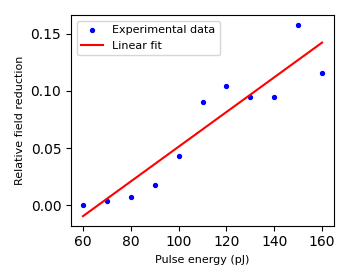

In [46]:
# Normalize intensity values (as done in the previous code)
intensity_values_s = np.array(intensity_values_12ps)
intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))

filed_12ps_s = (filed_12ps[0] - filed_12ps) / filed_12ps[0]

# Define linear and square root functions for fitting
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for the log-transformed data
params_linear_log_1, _ = curve_fit(linear_func, intensity_values_s, filed_12ps_s)

# Fit a quadratic function for the log-transformed data
params_quadratic_log_1, _ = curve_fit(square_root_func, intensity_values_s, filed_12ps_s)

# Create a plot for field reduction
fig = plt.figure(figsize=(3.5, 2.8))
ax = fig.add_subplot(111, label="1")

# Scatter plot for the experimental data (relative field reduction)
ax.scatter(np.array(intensity_values_12ps), filed_12ps_s, label='Experimental data', color='b', s=8)

# Plot the linear fit
ax.plot(np.array(intensity_values_12ps), linear_func(intensity_values_s, *params_linear_log_1), label='Linear fit', color='r')

# You can also plot the square-root fit if needed
# ax.plot(np.array(intensity_values_12ps), square_root_func(intensity_values_s, *params_quadratic_log_1), label='Square-root fit', color='g')

# Labeling and legends
ax.set_ylabel('Relative field reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


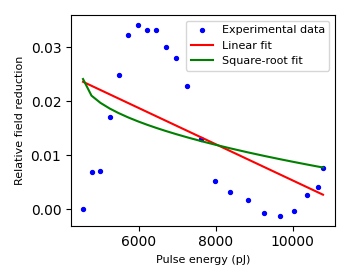

In [49]:
# Normalize intensity values (as done in the previous code)
intensity_values_s = np.array(intensity_values_12fs)
intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))

filed_12fs_s = (filed_12fs[0] - filed_12fs) / filed_12fs[0]

# Define linear and square root functions for fitting
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for the log-transformed data
params_linear_log_1, _ = curve_fit(linear_func, intensity_values_s, filed_12fs_s)

# Fit a quadratic function for the log-transformed data
params_quadratic_log_1, _ = curve_fit(square_root_func, intensity_values_s, filed_12fs_s)

# Create a plot for field reduction
fig = plt.figure(figsize=(3.5, 2.8))
ax = fig.add_subplot(111, label="1")

# Scatter plot for the experimental data (relative field reduction)
ax.scatter(np.array(intensity_values_12fs), filed_12fs_s, label='Experimental data', color='b', s=8)

# Plot the linear fit
ax.plot(np.array(intensity_values_12fs), linear_func(intensity_values_s, *params_linear_log_1), label='Linear fit', color='r')

# You can also plot the square-root fit if needed
ax.plot(np.array(intensity_values_12fs), square_root_func(intensity_values_s, *params_quadratic_log_1), label='Square-root fit', color='g')

# Labeling and legends
ax.set_ylabel('Relative field reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()